# Importing necessary libraries

In [ ]:
import cv2
import math
import urllib
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os

# Reading and Displaying Image

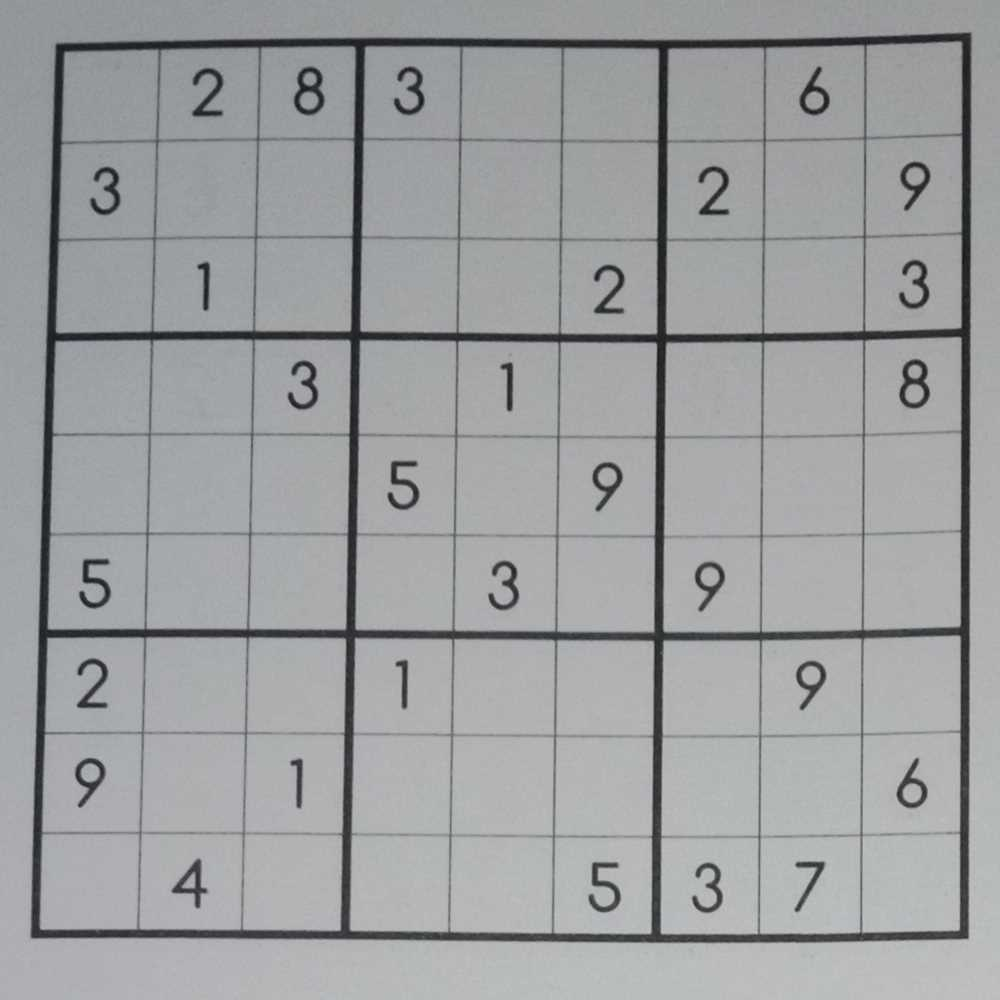

In [ ]:
image_path = "./09.jpg"  # Specify the path to the image file
image = cv2.imread(image_path)  # Read the image using OpenCV
cv2_imshow(image)  # Display the image using the cv2_imshow function

# Creating Mask for Color Range
To filter a certain color range from images and create a mask from it (coin image)

In [ ]:
def create_mask(image):

    """
    Creates a color-based mask for the input image.

    Parameters:
    - image: Input image.

    Returns:
    - closed_img: Masked image after applying dilation and closing operations.
    """

    # Define color range for the mask
    low_range = np.array([10, 50, 70], dtype="uint8")
    high_range = np.array([35, 255, 255], dtype="uint8")

    # Create a mask based on the color range
    mask = cv2.inRange(image, low_range, high_range)

    # Apply dilation to fill gaps in the mask
    kernel_dilate = np.ones((15, 15), np.uint8)
    dilated_img = cv2.dilate(mask, kernel_dilate, iterations=1)

    # Apply closing to remove small holes in the mask
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_img = cv2.morphologyEx(dilated_img, cv2.MORPH_CLOSE, kernel_close, None, None, 1, cv2.BORDER_REFLECT101)

    # Display the resulting mask
    cv2_imshow(closed_img)

    return closed_img


# Ordering Corners Function
to order the corner points of the contours

In [ ]:
def order_corners(corner, approx):

    """
    Orders corners of a polygon based on their position relative to the centroid.

    Parameters:
    - corner: Original corners of the contour.
    - approx: Approximated corners of the contour.

    Returns:
    - ordered_corners: Ordered corners of the contour in a specific arrangement.
    """

    # Initialize default values for corners
    top_left = [0, 0]
    top_right = [0, 0]
    bottom_right = [0, 0]
    bottom_left = [0, 0]

    # Extract x, y coordinates from the corners
    sort_corners = [(corner[0][0], corner[0][1]) for corner in approx]
    sort_corners = [list(ele) for ele in sort_corners]
    x, y = [], []

    # Calculate centroid of the corners
    for i in range(len(sort_corners[:])):
        x.append(sort_corners[i][0])
        y.append(sort_corners[i][1])
    centroid = [sum(x) / len(x), sum(y) / len(y)]

    # Determine the position of each corner relative to the centroid
    for _, item in enumerate(sort_corners):
        if item[0] < centroid[0]:
            if item[1] < centroid[1]:
                top_left = item
            else:
                bottom_left = item
        elif item[0] > centroid[0]:
            if item[1] < centroid[1]:
                top_right = item
            else:
                bottom_right = item

    # Arrange corners in a specific order
    ordered_points = [top_left, top_right, bottom_right, bottom_left]
    ordered_corners = np.array(ordered_points, dtype="float32")

    # Display ordered corners
    print("Ordered corners: ", ordered_corners)
    return ordered_corners


# Euclidean Distance Function
To calculate the dimensions of the sudoku frame for the prespective transform


In [ ]:
def euclidean_distance(point1, point2):
    # Calculate Euclidean distance between two points
    distance = np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    return distance

# Get Dimensions Function
To get the dimensions of the sudoku frame corner points


In [ ]:
def get_dimensions(ordered_corners):

    """
    Calculates the width, height, and perspective transformation corners based on ordered corners.

    Parameters:
    - ordered_corners: Ordered corners of an object in the image.

    Returns:
    - corners_of_perspective: Corners for the perspective transformation.
    - width: Calculated width of the object.
    - height: Calculated height of the object.
    """

    # Extract individual corners from the ordered set
    top_left, top_right, bottom_right, bottom_left = ordered_corners

    # Calculate width and height using Euclidean distance
    width1 = euclidean_distance(bottom_right, bottom_left)
    width2 = euclidean_distance(top_right, top_left)

    height1 = euclidean_distance(top_right, bottom_right)
    height2 = euclidean_distance(top_left, bottom_right)

    # Determine final width and height
    width = max(int(width1), int(width2))
    height = max(int(height1), int(height2))

    # Define corners of the perspective transformation
    corners_of_perspective = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

    return corners_of_perspective, width, height


# Get Contours Function
Get the contouring points for the sudoku frame


In [ ]:
def get_Contours(image):

    """
    Finds and processes contours in the input image.

    Parameters:
    - image: Input image after thresholding.

    Returns:
    - ordered_contours: Corners of the largest contour in the image, ordered appropriately.
    """

    # Find contours in the image
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the contour with the maximum area (largest object)
    contours = max(contours[0], key=cv2.contourArea)

    # Approximate the contour to reduce the number of vertices
    length = cv2.arcLength(contours, True)

    # Use the approxPolyDP to approximate the contour with a specified tolerance (0.07 times the arc length) to form a polygon approximately and get its corner points
    approx = cv2.approxPolyDP(contours, 0.07 * length, True)

    # Order the corners of the contour for further processing
    ordered_contours = order_corners(contours, approx)

    return ordered_contours


# Create Periodic Mask Function
Create a mask in the frequency domain to remove the periodic signal

In [ ]:
def create_mask_periodic(mask_size):

    """
    Creates a periodic mask with two circles to remove the sine wave.

    Parameters:
    - mask_size: Tuple specifying the size of the mask (rows, columns) which is equal to the image size.

    Returns:
    - final_mask: Periodic mask with two circles.
    """

    # create a black mask with the same image size
    mask = np.zeros(mask_size)

    # get the center of the 2 circles in the frequency domain (center determined by analysis)
    # we plotted the image in the frequency domain and analysed the frequency responses to specify the frequency to remove
    cx1, cy1 = (mask.shape[0] // 2) + 2, (mask.shape[1] // 2) + 2
    cx2, cy2 = (mask.shape[0] // 2) - 2, (mask.shape[1] // 2) - 2

    # Draw the first circle on the mask
    cir1 = cv2.circle(mask, (cx1, cy1), 2, (255, 255, 255), -1).astype(np.uint8)

    # Draw the second circle on the modified mask
    cir2 = cv2.circle(cir1, (cx2, cy2), 2, (255, 255, 255), -1).astype(np.uint8)

    # get the invertion of this mask so we remove the frequencies at the circle locations
    final_mask = ~cir2

    return final_mask


# Periodic Denoise Function
Remove the sine wave from the frequency domain by getting the fourier transform of the image and apply the mask on it

In [ ]:
def periodic_Denoise(img_gray):

    """
    Applies periodic denoising to the input grayscale image using frequency domain manipulation.

    Parameters:
    - img_gray: Grayscale input image.

    Returns:
    - img_lowpass_normalized: Denoised image after periodic denoising.
    """

    # Compute the 2D Fourier Transform of the grayscale image
    dft_img = np.fft.fft2(img_gray)
    dft_img_shift = np.fft.fftshift(dft_img)

    # Create a periodic mask for low-pass filtering
    mask = create_mask_periodic(dft_img.shape)
    dft_img_shifted_lowpass = np.multiply(dft_img_shift, mask)

    # Perform inverse Fourier Transform to obtain the denoised image
    img_lowpass = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted_lowpass)).real

    # Normalize the denoised image
    img_lowpass_normalized = cv2.normalize(img_lowpass, None, 0, 255, cv2.NORM_MINMAX)

    return img_lowpass_normalized


# Image Inversion Check Function
checks if the image is inverted in color or not (the dark mode image)

In [ ]:
def is_image_inverted_color(img, intensity_threshold=150):

    """
    Checks if an image is likely to have inverted colors based on its average intensity.

    Parameters:
    - img: Input image after the thresholding.
    - intensity_threshold: Threshold for average intensity, below which the image is considered inverted.

    Returns:
    - is_inverted: True if the image is likely to have inverted colors, False otherwise.
    """

    # Calculate average intensity of the image
    average_intensity = np.mean(img)

    # Check if average intensity is below a certain threshold
    if average_intensity < intensity_threshold:
        return True

    else:
        return False


# Get All Contour Points Function
get contour points without approximation (get the complete points)

In [ ]:
def get_all_contour_points(image):

    """
    Finds all contour points in the input image.

    Parameters:
    - image: Input image.

    Returns:
    - contours: List of contours, sorted by area in descending order.
    """

    # Find all contours in the image
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area in descending order
    contours = max(contours[0], key=cv2.contourArea)

    return contours


# Get Image Intensity Function

In [ ]:
def get_image_intensity(image):

    """
    Calculates the average intensity of the input image.

    Parameters:
    - image: Input image.

    Returns:
    - average_intensity: Average intensity of the image.
    """

    # Calculate average intensity
    average_intensity = np.mean(image)

    return average_intensity


# Get Image Contrast Function

In [ ]:
def get_image_contrast(image):

    """
    Calculates the contrast of the input image.

    Parameters:
    - image: Input image.

    Returns:
    - contrast: Contrast value of the image.
    """

    # Calculate image contrast
    contrast = np.max(image) - np.min(image)

    return contrast


# Basic Image Preprocessing and Initial Checks

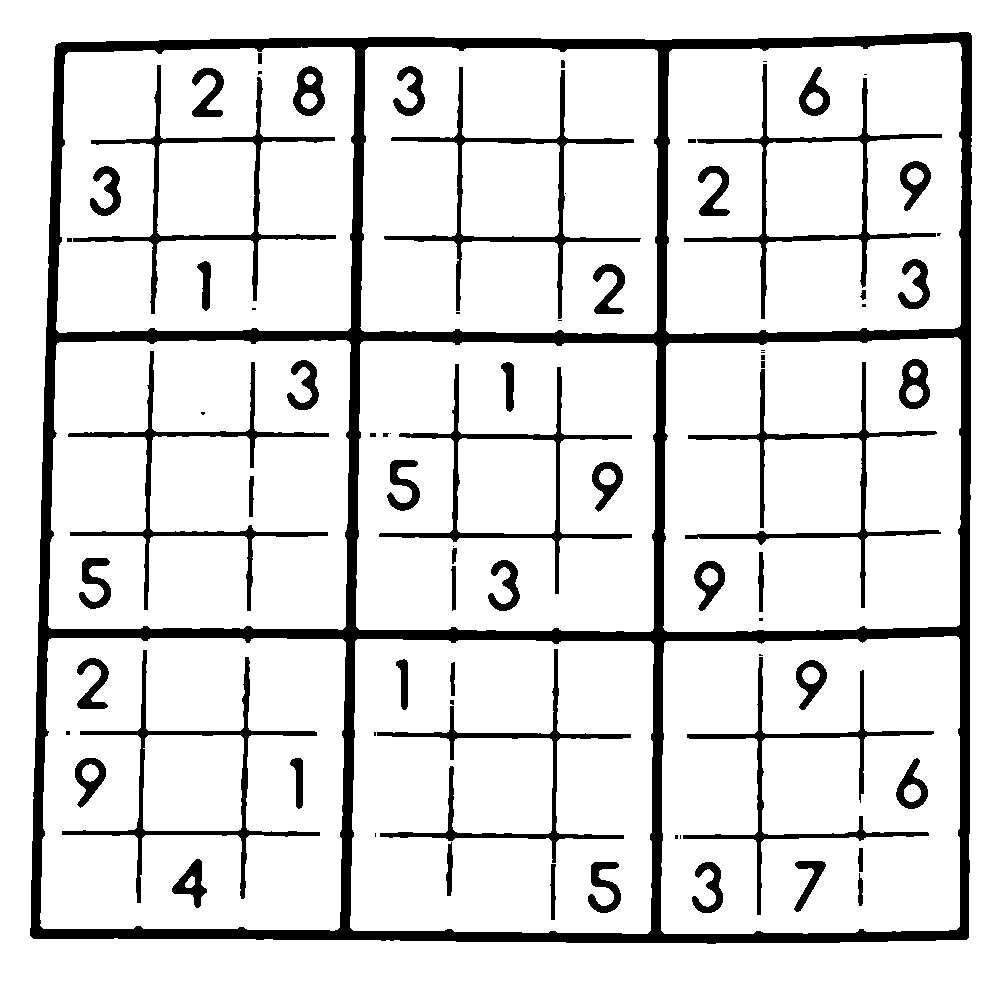

In [ ]:
# Convert image to grayscale and remove 'Sine Waves' periodic noise
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_lowpass_normalized = periodic_Denoise(image_gray)

# Removes salt and pepper noise and blurs the image
blur = cv2.medianBlur(img_lowpass_normalized.astype(np.uint8), 7)

# Apply adaptive thresholding for binary conversion
img_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 5) #apply normal threshold so the normal images has more white so the average intensity is high so pass the is_inverted check

# Check if the image is inverted
inverted = is_image_inverted_color(img_threshold)

# Display the thresholded image
cv2_imshow(img_threshold)

# Flags for various conditions
has_big_HSV_area = False
is_top_left_case = False
low_contrast = False
noisy = False

# Image Processing Conditions and pipelining

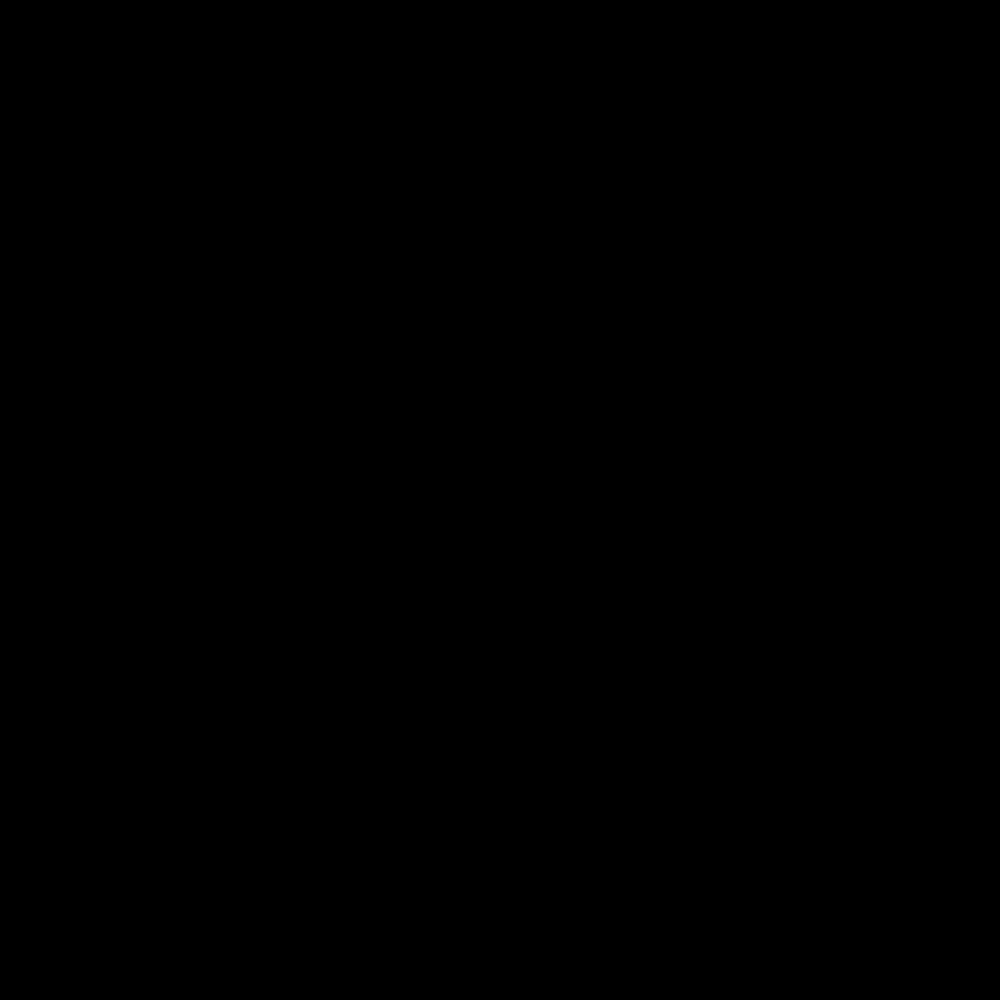

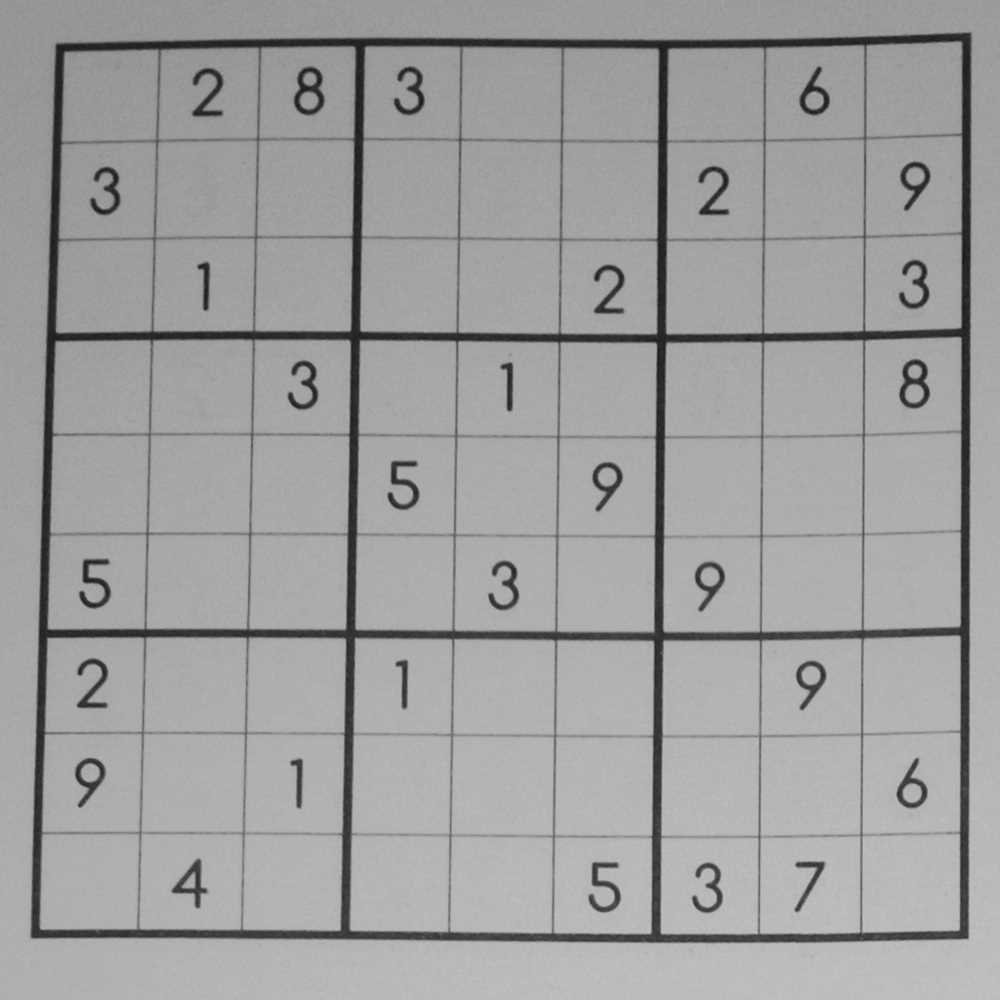

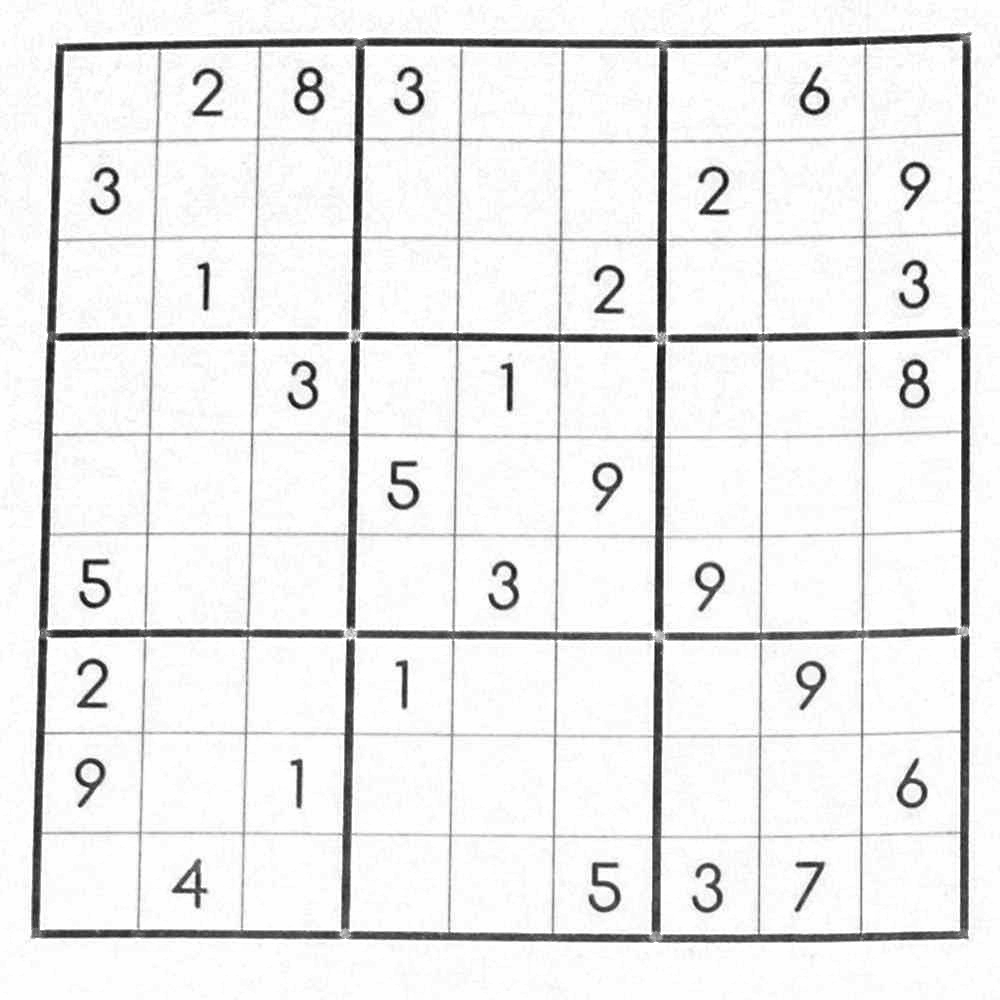

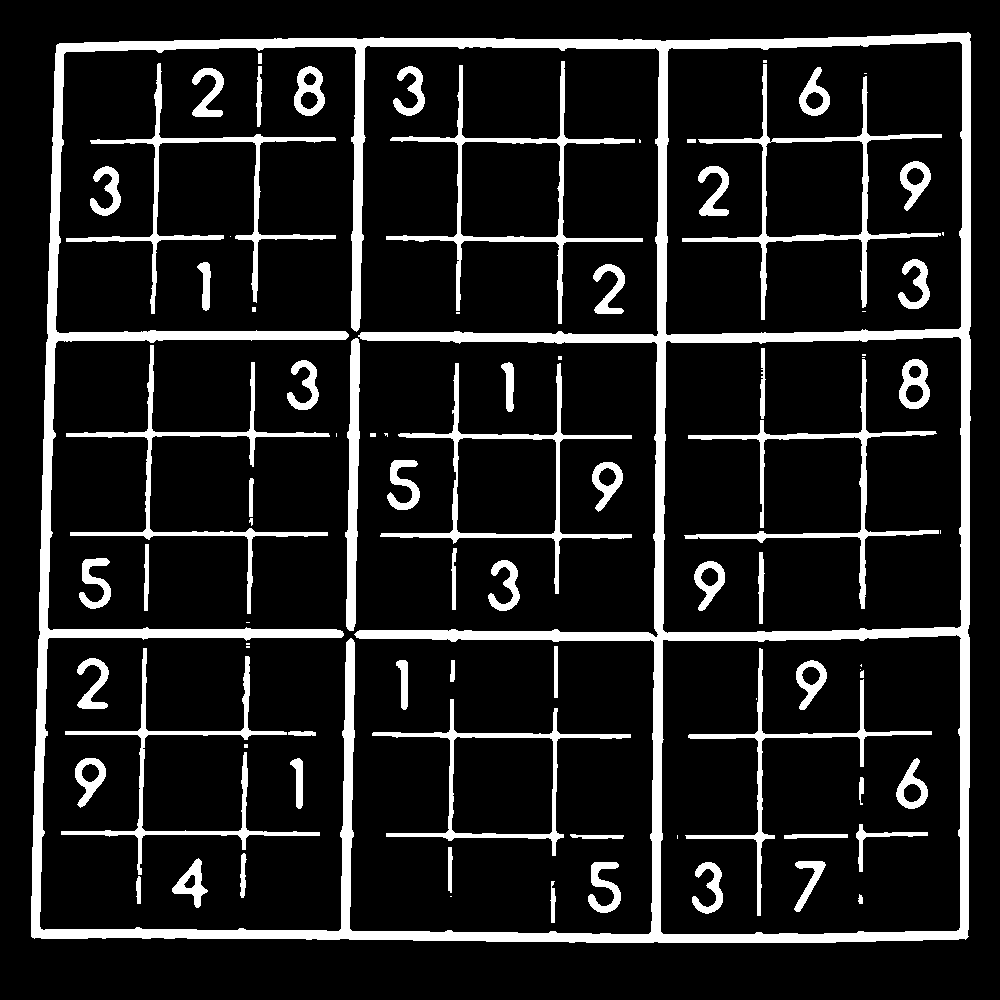

Ordered corners:  [[ 57.  44.]
 [970.  34.]
 [965. 939.]
 [ 31. 936.]]


In [ ]:
# Handling different image processing conditions based on 'inverted' flag

if inverted:
# Processing for already inverted images

    # Blurring and thresholding
    blur_inv = cv2.medianBlur(img_lowpass_normalized.astype(np.uint8),7)  # removes noise and blurs the image
    img_inv = cv2.adaptiveThreshold(blur_inv, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, -9)
    cv2_imshow(img_inv)

    # Detecting contours for perspective transform
    # Ready for prespective transform
    ordered_corners = get_Contours(img_inv)


# Handling non-inverted images

else:
# Check for the color filtered image

    # Convert the image to HSV and create a mask
    HSV_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = create_mask(HSV_img)

    # Check if the mask denotes a color filtered image by area comparison
    # Coin image has the largest area
    if np.count_nonzero(mask) > 27000:

        # Set flag for having a big HSV area
        has_big_HSV_area = True

        # Create an image by adding grayscale image and mask
        detected_output = cv2.add(image_gray, mask)

        # Threshold the detected output image
        _, img_threshold = cv2.threshold(detected_output, 119, 255, cv2.THRESH_BINARY_INV)

        # Define a kernel and perform dilation to connect gaps
        kernel2 = np.ones((25, 14), np.uint8)
        dilated_img = cv2.dilate(img_threshold, kernel2, iterations=1) # to connect gaps

        # Apply Canny edge detection because we will apply hough transform and as we know hough transform works better with canny
        img_canny = cv2.Canny(image=dilated_img, apertureSize=3, threshold1=120, threshold2=200, L2gradient=True)

        # Apply Hough Line Transform to connect gaps in the lines of the sudoko frame
        hough_lines = cv2.HoughLinesP(
            image=img_canny,
            rho=4,  # Distance resolution of the accumulator in pixels.
            theta=(math.pi / 180) * 2,  # Angle resolution of the accumulator in radians.
            threshold=200,  # Voting threshold for accumulator.
            lines=None,
            minLineLength=200,  # Line segments shorter than that are rejected.
            maxLineGap=90  # Maximum allowed gap between points on the same line to link them.
        )

        # Draw Hough lines on the dilated image to fill gaps  to get perfect contour
        for x0, y0, x1, y1 in hough_lines[:, 0]:
            cv2.line(dilated_img, (x0, y0), (x1, y1), (255, 255, 255), 8, cv2.LINE_AA)

        # Obtain contours for perspective transform
        ordered_corners = get_Contours(dilated_img)

    # Processing for images that are not inverted or color filtered images
    else:
        # Preprocessing steps for normal pipeline

        # Morphological operations for image enhancement
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
        closing_result = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel)
        div= np.float32 (image_gray) / closing_result

        # Perform contrast stretching
        contrast_stretched = np.uint8(cv2.normalize(div, None, 0, 255, cv2.NORM_MINMAX))


        # Display the original and contrast-stretched images
        cv2_imshow(image_gray)
        cv2_imshow(contrast_stretched)

        # Blur the contrast-stretched image using median filter to remove salt and pepper noise
        blur = cv2.medianBlur(contrast_stretched, 7)

        # Apply adaptive thresholding to obtain a binary image
        adaptive_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 111, 7)
        cv2_imshow(adaptive_threshold)

        # Find contours and sort based on area
        contours, _ = cv2.findContours(adaptive_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        corners = sorted(contours, key=cv2.contourArea, reverse=True)

        # Obtain contours for perspective transform
        ordered_corners = get_Contours(adaptive_threshold)

        # Get the minimum area rectangle and extract corners
        rect = cv2.minAreaRect(corners[0])
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Find the top-left corner of the minimum area rectangle
        top_left_index = np.argmin(np.sum(box, axis=1))
        top_left_corner = box[top_left_index]


        # Checking for images with large gaps or missing lines in the frame
        if abs(ordered_corners[0][0] - top_left_corner[0]) > 55:


            is_top_left_case = True

            # Apply adaptive thresholding with specific parameters
            adaptive_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 111, 4)

            # Define a kernel and perform dilation to connect gaps
            kernel_morph = np.ones((3, 12), np.uint8)
            img_morph = cv2.dilate(adaptive_threshold, kernel_morph, iterations=1)

            # Define a kernel and perform opening to remove the points on the side
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            opening_result = cv2.morphologyEx(adaptive_threshold, cv2.MORPH_OPEN, kernel)

            # Apply Canny edge detection because we will apply hough transform and as we know hough transform works better with canny
            img_canny = cv2.Canny(image=opening_result, apertureSize=3, threshold1=120, threshold2=200, L2gradient=True)

            # Apply Hough Line Transform to connect gaps in the lines of the sudoko frame
            hough_lines = cv2.HoughLinesP(
                image=img_canny,
                rho=4,  # Distance resolution of the accumulator in pixels.
                theta=(math.pi / 180) * 2,  # Angle resolution of the accumulator in radians.
                threshold=200,  # Voting threshold for accumulator.
                lines=None,
                minLineLength=200,  # Line segments shorter than that are rejected.
                maxLineGap=90  # Maximum allowed gap between points on the same line to link them.
            )
            # Draw detected Hough lines on the image of the opening result
            for x0, y0, x1, y1 in hough_lines[:, 0]:
                cv2.line(opening_result, (x0, y0), (x1, y1), (255, 255, 255), 8, cv2.LINE_AA)

            # Find contours and sort based on area
            contours, _ = cv2.findContours(img_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            corners = sorted(contours, key=cv2.contourArea, reverse=True)
            rect = cv2.minAreaRect(corners[0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(opening_result, [box], 0, (255, 255, 255), 2)

            # Obtain contours for perspective transform
            ordered_corners = get_Contours(opening_result)



# Handling Low Contrast or Noisy Images

In [ ]:
if np.mean(img_lowpass_normalized) < 160:
    if np.mean(img_lowpass_normalized) > 150:
        # Condition for low contrast scenario

        # Set flag for low contrast
        low_contrast = True

        # Blur the gray image using median filter to remove salt and pepper noiseg
        blur = cv2.medianBlur(image_gray.astype(np.uint8), 3) # removes salt and pepper noise and blurs the image
        ret,thresh1 = cv2.threshold(blur,32,255,cv2.THRESH_BINARY_INV)

        # Define a kernel and perform closing to close gaps of the numbers and lines
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        closing_result1 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)

        # Define a kernel and perform dilation to connect gaps of the lines
        kernel2 = np.ones((2, 8), np.uint8)
        img_erosion2 = cv2.dilate(closing_result1, kernel2, iterations=1)

        # Define a kernel and perform erosion to return numbers to its original shapes and remove any noise
        kernel = np.ones((2, 4), np.uint8)
        img_erosion = cv2.erode(img_erosion2, kernel, iterations=1)

        low_contrast_img = img_erosion

    elif not inverted:

        noisy = True
        # Apply median blur again with a larger kernel for noise reduction and specifically salt and pepper noise
        blur = cv2.medianBlur(blur, 7)
        noisy_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 81, 25)


# Final Image Processing and Perspective Transformation

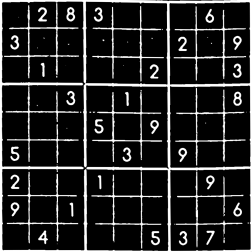

In [ ]:
# Which image to apply prespective transform on?

if inverted:
  final_image = img_inv

elif has_big_HSV_area:
  final_image = img_threshold

elif noisy:
  final_image = noisy_threshold

elif low_contrast:
  final_image = low_contrast_img

elif is_top_left_case:

  gapped_image = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 81, 6)

  # Define a kernel and perform closing to close gaps of the numbers and lines
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
  closing_result = cv2.morphologyEx(gapped_image, cv2.MORPH_CLOSE, kernel)

  final_image = closing_result

else:
  # Apply default adaptive thresholding for normal images
  adaptive_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 111, 5)

  final_image = adaptive_threshold


dimensions, width, height = get_dimensions(ordered_corners)

matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

transformed_image = cv2.warpPerspective(final_image, matrix, (width, height))

transformed_image = cv2.resize(transformed_image, (252, 252), interpolation=cv2.INTER_AREA)

cv2_imshow(transformed_image)

# Separate the number tiles
Finally, you get each value in a tile of its own, ready to go to phase 2 (OCR).

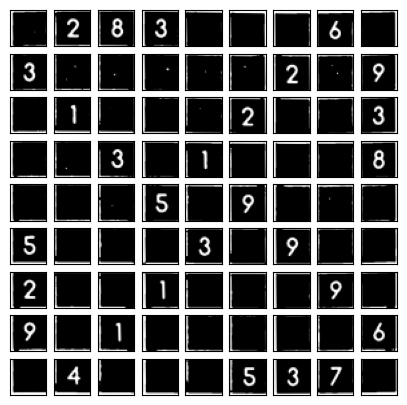

In [ ]:

M = transformed_image.shape[0] // 9
N = transformed_image.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = transformed_image[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

# Preprocessing The Image for Template Matching

In [ ]:
def preprocess_image(cell_image):

    """
    Preprocesses a cell image using a series of image processing techniques.

    # Image Processing Techniques:
    # 1. Resize
    # 2. Sharpening Filter
    # 3. Gaussian Blur
    # 4. Grayscale Conversion
    # 5. Otsu's Thresholding
    # 6. Morphological Closing
    # 7. Masking
    # 8. Connected Component Labeling
    # 9. Dilation and Erosion
    # 10. Additional Morphological Operations
    # 11. Horizontal and Vertical Line Removal
    # 12. Connected Component Filtering

    Parameters:
    - cell_image: Input image of a cell.

    Returns:
    - output: Processed image with removed lines and connected components.
    """

    # Display original image
    # plt.imshow(cell_image)
    # plt.title('Original Image')
    # plt.axis('off')
    # plt.show()

    # Resize the input image to a standard size of 100x100 pixels.
    resized_image = cv2.resize(cell_image, (100, 100))

    # # Display resized image
    # plt.imshow(resized_image)
    # plt.title('Resized Image')
    # plt.axis('off')
    # plt.show()

    # Apply a sharpening filter to the resized image to enhance the edges.
    kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]])
    sharpened_image = cv2.filter2D(resized_image, -1, kernel)

    # Display sharpened image
    # plt.imshow(sharpened_image, cmap='gray')
    # plt.title('Sharpened Image')
    # plt.axis('off')
    # plt.show()

    # Apply a Gaussian blur to the sharpened image.
    Gaussian_image = cv2.GaussianBlur(sharpened_image, (5, 5), 0)

    # Convert the image to grayscale if it is not already.
    if len(Gaussian_image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding method to the grayscale image.
    _, otsu_threshold = cv2.threshold(Gaussian_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Display otsu Threshold image
    # plt.imshow(otsu_threshold, cmap='gray')
    # plt.title('Otsu Image')
    # plt.axis('off')
    # plt.show()

    # Perform a morphological closing operation on the thresholded image.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed_image = cv2.morphologyEx(otsu_threshold, cv2.MORPH_CLOSE, kernel)

    # Display closed image
    # plt.imshow(closed_image, cmap='gray')
    # plt.title('Closed Image')
    # plt.axis('off')
    # plt.show()

    # Perform a morphological opening operation on the closed image.
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)
    # plt.imshow(opened_image, cmap='gray')
    # plt.title('Opened Image')
    # plt.axis('off')
    # plt.show()

    # Create a mask of the same size as the image, filled with True
    mask = np.ones(opened_image.shape, dtype=bool)

    # Set the frame region of the mask to False.

    # Set the top 10 rows.
    mask[:10, :] = False

    # Set the bottom 20.
    mask[-20:, :] = False

    # Set the left 15.
    mask[:, :15] = False

    # Set the right 25 columns.
    mask[:, -25:] = False

    # Apply the mask to the opened image.
    image_without_frame = np.where(mask,  opened_image, 0)

    # Find connected components in the image without the frame.
    num_labels, labels = cv2.connectedComponents(image_without_frame,connectivity=8)

    # Create a structuring element for closing.
    kernel = np.ones((10,10),np.uint8)

    # Initialize a flag to track whether any pair of components are close enough.
    close_components_exist = False

    # plt.imshow(image_without_frame, cmap='gray')
    # plt.title('Image without frame')
    # plt.axis('off')
    # plt.show()

    # If there are more than 2 components, check the distance between each pair of components.
    if num_labels > 2:
        # Iterate over each component.
        for i in range(1, num_labels):
                # Isolate the current component.
                component1 = (labels == i)
                # Count the number of white pixels in the component
                white_pixels1 = np.sum(component1)

                # If the component has less than 30 white pixels, skip it
                if white_pixels1 < 30:
                    continue
                # If the component has more than 700 white pixels, skip it
                if white_pixels1 > 700:
                    continue

                # Iterate over each component that comes after the current component in the list
                for j in range(i+1, num_labels):
                    # Isolate the next component
                    component2 = (labels == j)

                    # Count the number of white pixels in the component
                    white_pixels2 = np.sum(component2)

                    # If the component has less than 30 white pixels, skip it
                    if white_pixels2 < 30:
                        continue

                    min_distance = np.inf
                    # Calculate the minimum distance between the components
                    for point1 in np.array(component1.nonzero()).T:
                        for point2 in np.array(component2.nonzero()).T:
                            # Calculate the Euclidean distance between the two points
                            distance = np.linalg.norm(point1 - point2)
                            # If the calculated distance is less than the current minimum distance, update the minimum distance
                            if distance < min_distance:
                                min_distance = distance

                    # If the minimum distance is less than the threshold, set the flag to True and break the loop
                    if min_distance < 12:
                        close_components_exist = True
                        break
                # If the flag is True, break the outer loop
                if close_components_exist:
                    break


    # If the flag is True, apply the closing operation to the image
    if close_components_exist:
        # Count the number of white pixels in the image
        num_white_pixels = np.sum(image_without_frame == 255)

        if num_white_pixels == 569 or num_white_pixels == 595:
             image_without_frame = cv2.dilate(image_without_frame, kernel=np.ones((4,4),np.uint8))

        # Perform dilation on the image
        image_without_frame = cv2.dilate(image_without_frame, kernel, iterations=1)

        # Perform erosion on the image
        image_without_frame = cv2.erode(image_without_frame, kernel, iterations=1)

        # Perform dilation on the image
        image_without_frame = cv2.dilate(image_without_frame, kernel=np.ones((4,4),np.uint8))

        # Combine the processed part of the image with the frame from the original image

        opened_image = np.where(mask, image_without_frame, opened_image)

    # plt.imshow(opened_image, cmap='gray')
    # plt.title('Opened image after connecting cutoff components')
    # plt.axis('off')
    # plt.show()

    # Define the size of the frame to be removed
    frame_size = 25

    # Create masks for the horizontal and vertical frames and set them to 1 (white)
    mask_horizontal = np.zeros_like(opened_image)
    mask_horizontal[:frame_size, :] = 1  # Top frame
    mask_horizontal[-frame_size:, :] = 1  # Bottom frame
    mask_vertical = np.zeros_like(opened_image)
    mask_vertical[:, :16] = 1  # Left frame
    mask_vertical[:, -frame_size:] = 1  # Right frame

    # Apply the masks to the binary image
    masked_image_horizontal = cv2.bitwise_and(opened_image, opened_image, mask=mask_horizontal)
    masked_image_vertical = cv2.bitwise_and(opened_image, opened_image, mask=mask_vertical)

    # Define kernels for horizontal and vertical lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (44, 3))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 44))

    # Use morphological opening to remove the horizontal and vertical lines
    removed_horizontal = cv2.morphologyEx(masked_image_horizontal, cv2.MORPH_OPEN, horizontal_kernel)
    removed_vertical = cv2.morphologyEx(masked_image_vertical, cv2.MORPH_OPEN, vertical_kernel)

    # Combine the effects of removing horizontal and vertical lines
    removed_lines = cv2.add(removed_horizontal, removed_vertical)

    # Subtract the lines from the original image
    removed_lines_image = cv2.subtract(opened_image, removed_lines)

    # plt.imshow(removed_lines_image, cmap='gray')
    # plt.title('Removed lines')
    # plt.axis('off')
    # plt.show()

    # Define the size of the second frame to be removed
    frame_size_2 = 7
    top_frame_size_2 = 13

    # Create masks for the second horizontal and vertical frames and set them to 1 (white)
    mask_horizontal_2 = np.zeros_like(removed_lines_image)
    #The : operator in [:top_frame_size_2, ...] means “all indices from the start up to top_frame_size_2”.
    #The removed_lines_image.shape[1]//2: part means “all columns from the middle of the image to the end”.
    mask_horizontal_2[:top_frame_size_2, removed_lines_image.shape[1]//2+20:] = 1  # Top frame from the middle to the right
    #The -frame_size_2: part means “the last frame_size_2 rows”
    #removed_lines_image.shape[1]//2:removed_lines_image.shape[1]//2+15 means “15 columns starting from the middle of the image”.
    mask_horizontal_2[-frame_size_2:, removed_lines_image.shape[1]//2:removed_lines_image.shape[1]//2+15] = 1  # Bottom frame starting from the middle and extending 15 pixels to the right
    mask_vertical_2 = np.zeros_like(removed_lines_image)
    # The removed_lines_image.shape[0]//2: part means “all rows from the middle of the image to the end”,
    # and -frame_size_2: means “the last frame_size_2 columns”.
    mask_vertical_2[removed_lines_image.shape[0]//2:, -frame_size_2:] = 1  # Right frame starting for the middle of the image vertically and extending to the bottom edge of the image

    # Apply the masks to the binary image
    masked_image_horizontal_2 = cv2.bitwise_and(removed_lines_image, removed_lines_image, mask=mask_horizontal_2)
    masked_image_vertical_2 = cv2.bitwise_and(removed_lines_image, removed_lines_image, mask=mask_vertical_2)

    # Define kernels for horizontal and vertical lines
    horizontal_kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    vertical_kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))

    # Use morphological opening to remove the horizontal and vertical lines
    removed_horizontal_2 = cv2.morphologyEx(masked_image_horizontal_2, cv2.MORPH_OPEN, horizontal_kernel_2)
    removed_vertical_2 = cv2.morphologyEx(masked_image_vertical_2, cv2.MORPH_OPEN, vertical_kernel_2)

    # Combine the effects of removing horizontal and vertical lines
    removed_lines_2 = cv2.add(removed_horizontal_2, removed_vertical_2)

    # Subtract the lines from the original image
    removed_lines_2_image = cv2.subtract(removed_lines_image, removed_lines_2)

    # plt.imshow(removed_lines_2_image, cmap='gray')
    # plt.title('Removed lines 2')
    # plt.axis('off')
    # plt.show()

    # Perform connected component labeling
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(removed_lines_2_image, connectivity=8)

    # Create a black square of size 100x100
    # This creates an empty image of size 100x100 pixels filled with black color
    output = np.zeros((100, 100), dtype=np.uint8)

    # Define the minimum size of connected components to keep
    # This is the threshold below which the connected components will be discarded
    min_size = 250

    # Loop through the connected components
    for i in range(1, num_labels):
        # If the size of the connected component is larger than min_size, keep it
        # This checks if the current component's size is larger than the threshold
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            # Create a binary image of the same size as the original image
            # Set the pixels belonging to the current component to white (255)
            component = np.zeros_like(labels)
            component[labels == i] = 255
            # Calculate the position where the component will be placed in the output image
            # The component is placed in the center of the output image
            x = output.shape[1] // 2 - component.shape[1] // 2
            y = output.shape[0] // 2 - component.shape[0] // 2
            # Place the component in the output image
            output[y:y+component.shape[0], x:x+component.shape[1]] = component

    # The following commented lines are used to display the final output image
    # plt.imshow(output, cmap='gray')
    # plt.title('Final output')
    # plt.axis('off')
    # plt.show()

    output = cv2.resize(output, (28, 28))

    return output





# Reading Templates from folder

In [ ]:
def read_images_from_folder(folder_path):
    images = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            number_value = int(filename.split('_')[0])

            #Create a list for each number if it doesn't exist
            if number_value not in images:
                images[number_value] = []

            #Append the image to the list
            images[number_value].append((image,filename))
    return images

# Template Matching and its Helper Function

In [ ]:
'''
# This function performs scale-invariant template matching for a single template.
# It iterates over a range of scales (resizing factors) from 1.0 to 1.5
# For each scale, it resizes the template, checks if the resized template is smaller than the input image, and then performs template matching using cv2.matchTemplate.
# It keeps track of the maximum correlation (max_corr) and the corresponding scale and location.
# After iterating through all scales, it returns the best scale, location, and maximum correlation.
'''
def scale_invariant_template_matching_single(image, template):
    max_corr = -1
    best_scale = 1.0
    best_loc = None

    for scale in np.linspace(1.0, 1.5, num=10):
        resized_template = cv2.resize(template, None, fx=scale, fy=scale)

        # Check sizes before template matching
        if resized_template.shape[0] >= image.shape[0] or resized_template.shape[1] >= image.shape[1]:
            continue

        result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)
        _, max_corr_curr, _, max_loc_curr = cv2.minMaxLoc(result)

        if max_corr_curr > max_corr:
            max_corr = max_corr_curr
            best_scale = scale
            best_loc = max_loc_curr

    return best_scale, best_loc, max_corr

In [ ]:
'''
This function takes an image and a dictionary of templates (templates_dict) as input. The templates dictionary associates each digit with a list of templates for that digit.
 It iterates over each digit and its associated templates.
 For each template, it calls the scale_invariant_template_matching_single function to find the best match.
 It keeps track of the template that gives the maximum correlation (max_corr) and the corresponding digit.
 After iterating through all templates, it checks if the maximum correlation is above the specified threshold.
If it is, it returns the digit associated with the best template. Otherwise, it returns None.
'''
def scale_invariant_template_matching(image, templates_dict, threshold=0.7):
    max_corr = -1
    best_template_name = None
    best_number_value = None

    for number_value, templates in templates_dict.items():
        for template, template_name in templates:
            scale, loc, correlation = scale_invariant_template_matching_single(image, template)
            if correlation > max_corr:
                max_corr = correlation
                best_template_name = template_name
                best_number_value = number_value

    # Check if the correlation is below the threshold
    if max_corr < threshold:
        return 0, None  # No number detected
    else:
        return best_number_value, best_template_name

# Solving the Sudoku

sudoku functions

In [ ]:
# Function to convert the Sudoku board into a string representation
def textize_sudoku(board):
    sudoku_ocr_text = ''
    # Iterate over each row in the board
    for i, row in enumerate(board):
        # Add a separator line every 3 rows
        sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ ' if (i%3 == 0) else ' │           │           │           │ '
        sudoku_ocr_text += '\n'
        sudoku_ocr_text += ' │ '
        # Iterate over each cell in the row
        for j, cell in enumerate(row):
          # Add the cell value to the string, or a space if the cell is empty
          sudoku_ocr_text += f"{cell if cell != 0 else ' '} {' ' if (j%3 != 2) else '│'} "
        sudoku_ocr_text += '\n'
    # Add a final separator line at the end
    sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ '
    return sudoku_ocr_text

# Function to find the next empty cell in the board
def find_next_empty_cell(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)
    return None

# Function to check if a number can be placed in a given position
def is_valid(board, num, row, col):
    for i in range(9):  # row and column checks
        if board[row][i] == num and col != i: return False
        if board[i][col] == num and row != i: return False

    # Check box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3
    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if board[i][j] == num and (i, j) != (row, col):
                return False
    # If the number does not appear in the row, column, or box, return True
    return True

# Function to solve the Sudoku board using backtracking
def solve(board):
    # Find the next empty cell
    empty_cell_pos = find_next_empty_cell(board)
    # If there are no empty cells, the board is solved
    if empty_cell_pos == None: return True
    row, col = empty_cell_pos
    # Try each number from 1 to 9 in the empty cell
    for num in range(1, 10):
        # If the number is valid, place it in the cell
        if is_valid(board, num, row, col):
            board[row][col] = num
            if solve(board): return True
             # If the rest of the board can't be solved, remove the number from the cell and continue
            board[row][col] = 0
    # If no number can be placed in the cell, return False
    return False

# Function to solve the Sudoku board and return a board with the original numbers bolded and the filled numbers in red
def solve_sudoku(board):
    sudoku_to_solve = np.copy(board)
    solve(sudoku_to_solve)
    solved_sudoku = []
    for i in range(9):
        solved_sudoku.append([])
        for j in range(9):
            # If the cell was originally empty, add the filled number in red
            # If the cell was not empty, add the original number in bold
            solved_sudoku[i].append("\033[1m"+str(board[i][j])+"\033[0m" if (board[i][j] != 0) else "\033[91m"+str(sudoku_to_solve[i][j])+"\033[0m")
    return solved_sudoku


calling the functions to solve the sudoku

In [ ]:
# Read templates from the 'templates' folder
templates = read_images_from_folder('templates')

#  Initialize an empty Sudoku board
sudoku_board = [[0]*9 for _ in range(9)]

# Iterate over the tiles and perform template matching
for row in range(9):
    for col in range(9):
        # Preprocess the image tile at the current row and colum
        tile_image = preprocess_image(number_tiles[row][col])
        # Perform scale-invariant template matching
        best_match, best_template_name = scale_invariant_template_matching(tile_image, templates)
        if best_match is not None:
            # If a match is found, update the Sudoku board at the current row and column with the matched digit
            # Calculate the row and column index for the Sudoku board
            sudoku_board[row][col] = best_match
            # Update the Sudoku board with the detected digit

#Printing The output

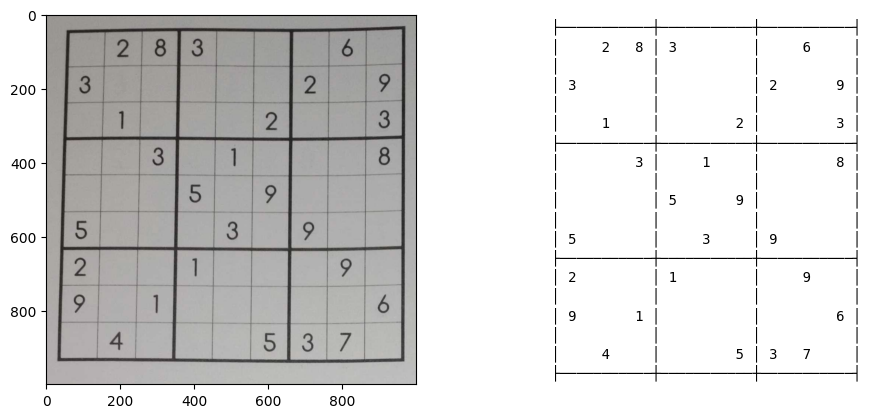

In [ ]:
plt.imshow(image);
sudoku_board_array = np.array(sudoku_board)
plt.figtext(1, 0.125, textize_sudoku(sudoku_board_array.reshape((9, 9)).astype(int)), fontfamily='monospace')
plt.show()

In [ ]:
print(textize_sudoku(solve_sudoku(sudoku_board)))

 ├───────────┼───────────┼───────────┤ 
 │ 4   2   8 │ 3   9   7 │ 1   6   5 │ 
 │           │           │           │ 
 │ 3   5   7 │ 6   4   1 │ 2   8   9 │ 
 │           │           │           │ 
 │ 6   1   9 │ 8   5   2 │ 7   4   3 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 7   9   3 │ 2   1   4 │ 6   5   8 │ 
 │           │           │           │ 
 │ 1   6   2 │ 5   8   9 │ 4   3   7 │ 
 │           │           │           │ 
 │ 5   8   4 │ 7   3   6 │ 9   1   2 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 2   7   5 │ 1   6   3 │ 8   9   4 │ 
 │           │           │           │ 
 │ 9   3   1 │ 4   7   8 │ 5   2   6 │ 
 │           │           │           │ 
 │ 8   4   6 │ 9   2   5 │ 3   7   1 │ 
 ├───────────┼───────────┼───────────┤ 
